# *Analytics on Trace Data*

In this notebook we're tying to understand the Trace data, such as basic statistics and stuff. The aim of this notebook in the end is to _collapse the equal-cost multipaths_ or something sround that to reduce the complexity of the data. We here in this notebook look at distributions of data to understand the generalnature of trace data. 

We'll be pulling data from Kibana using the ElasticSearch Python API and plotting some data for easier understanding, we only use the data in production not the test data.


In [14]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan, bulk
from time import time, strftime, localtime, sleep
from datetime import datetime, timedelta
from itertools import islice
import pickle
import numpy as np
import pandas as pd
import json
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.axes as ax

#### *Custom Modules*
We use three custom modules which assist us. 

The first module contains various types of queries callable as functions, the second module is a utility module for plotting, getting correct date formats etc.. and the thied module helps us move hops data from Kibana to Neo4j for a source-destination pair.


(The auto-reload extension, always reloads the modules without having the need to restart the IPython Kernel. Helps a lot in development of custom modules like these.)

In [15]:
%load_ext autoreload
%autoreload 2

import Utility_Modules.r_utils as ut
import Utility_Modules.elasticqueries as qrs
import Utility_Modules.kibana_to_neo_pipe as pipe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### *Conecting to ElasticSearch*
This connection object work throughout the notebook to retreive data from the ElasticSearch Kibana Instance

Enter your user and passwd fields to connect to the database. Change from None to String type

In [3]:
user = None
passwd = None
if user is None and passwd is None:
    with open("creds.key") as f:
        user = f.readline().strip()
        passwd = f.readline().strip()
credentials = (user, passwd)
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=240, http_auth=credentials)

print("Connection Successful") if es.ping() == True else print("Connection Unsuccessful")

Connection Successful


------
### *Distinct Counts*

In the next cell we inspect the **count of distinct values** (Fields Specified Below) in the ps trace data in the last 90 day time frame to get some insights on the data.


* dest_host
* src_host
* dest
* src
* dest_site
* src_site

**\***
There is an aditional function present here *__getUniqueCountBy()__* which returns a list of the unique values and not just the length. Although, it prints out the size of the array when executing. It takes in the same argument as the function below.


In [ ]:
countOf = ['dest_host', 'dest', 'src_host', 'src','src_site', 'dest_site']
for i in countOf:
    print("{:9s} : {:4d}".format(i, qrs.getUniqueCount(es,'ps_trace',i, ut.getDateFormat(delta=91), ut.getDateFormat())))

### *Looking at the Numbers Above*

**Q :** Why is the number of ip's per site more than 1 (we see upto 7 here)

**A :** "Site" is typically equivalent to a WLCG Tier-2.  Some of our Tier-2s actually are composed of more than one institution.  Each distinct network location (different subnet for example) should have two different perfSONAR toolkits installed; one for latency measurement and one for bandwidth measurement.   A typical "site" at only one institution, should have 2 different IPs; one for latency and one for bandwidth.  A site can have multiple networks to monitor and can therefore have multiple associated IPs

**Q :** Why are there 2 or more ips per hostname

**A :** Some perfSONAR instances have both IPv4 and IPv6 addresses.  This is called being dual-stacked.   That is ONE way to have multiple IP addresses for a specific perfSONAR toolkit instance.   It is also possible to add more IP addresses (which may end up testing different data paths through the network).  Each interface could have additional IP addresses added, either IPv4 or IPv6.  Usually additional IPv4/IPv6 addresses (beyond the first) would be added into specific different VLANs.


**Q :** Why are there more dest_hosts than src_hosts

**A :** PerfSonar gathers aLL the data present from each node, some of which may NOT be data the we scheduled/requested, i.e., they can be from "local" test configurations or even other PWA instances. Because of this, there can be an asymmetry in source vs destination, because we ask sources to run tests and some of the destinations are NOT our systems.

**\*** Thanks **Shawn McKee** for helping answer these questions.

-----
**Frequency Distribution of Source and Destination Hosts **

In [9]:
src_data = qrs.getUniqueCountBy(es,'ps_trace','src_host',ut.getDateFormat(delta=91), ut.getDateFormat())
dest_data = qrs.getUniqueCountBy(es,'ps_trace','dest_host',ut.getDateFormat(delta=91), ut.getDateFormat())

Size : 188
Size : 259


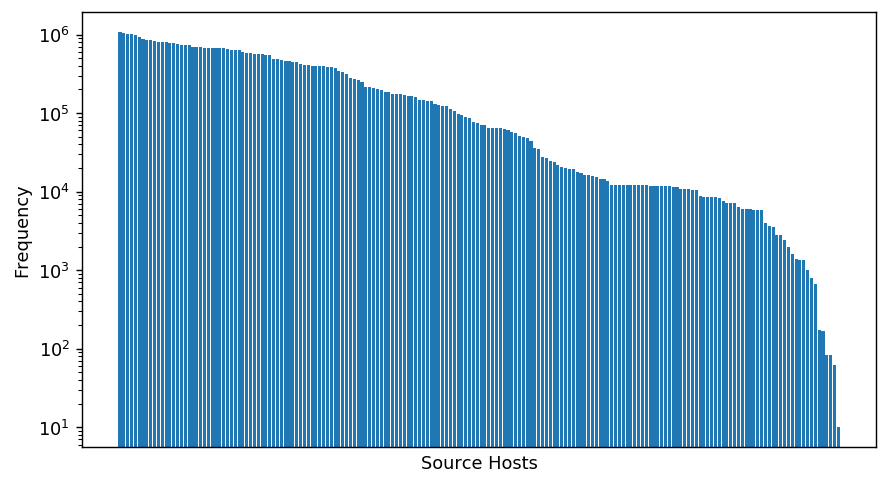

In [10]:
ut.plotByHist(src_data,"Source Hosts",plt)

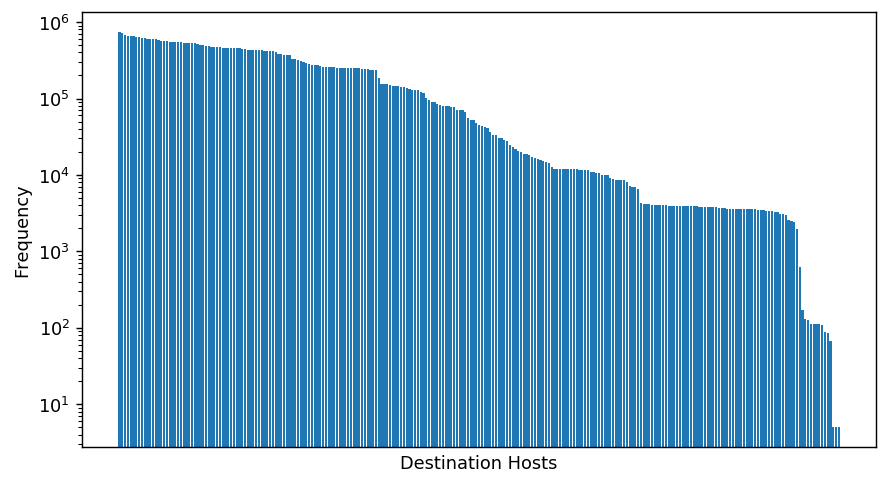

In [11]:
ut.plotByHist(dest_data, 'Destination Hosts', plt)

### *Conclusion*
This helps us see that all the sources do not talk all the destinations and some talk to more than the others. The reason behind this is the mesh architecture. All the hosts present in the mesh talk to every other host in the mest but not outside the mesh. And some nodes are associated with more meshes than others.

-----
### *Frequency Distribution of Paths between all pair of nodes (in the past three months from today)*

We use the results captured another script here for this usecase, which is also placed in the Utility_Modules folder.
That script provides us with two values of our interest, total path between a source and destination and number of paths whihc were take more than once. We did this to reduce the complexity in our data and maybe look it as an alternative to removing equal cost multipaths. 

In [6]:
with open('Results/Threshold_1.pickle',"rb") as f:
    only_one = pickle.load(f)

SrcDestPairs = {"Source":[], "Destination":[], "Total":[], "MoreThanOne":[]}
for d in only_one:
    SrcDestPairs['Source'].append(d['source'])
    SrcDestPairs['Destination'].append(d['destination'])
    SrcDestPairs['Total'].append(d['total'])
    SrcDestPairs['MoreThanOne'].append(d['topk'])

src_dest_path_df = pd.DataFrame(SrcDestPairs)
src_dest_path_df['Once'] = src_dest_path_df['Total'] - src_dest_path_df['MoreThanOne']

In [7]:
src_dest_path_df.head()

,Source,Destination,Total,MoreThanOne,Once
0,202.140.191.90,109.105.124.88,26,12,14
1,202.140.191.90,131.154.254.11,49,26,23
2,202.140.191.90,193.109.172.187,33,22,11
3,202.140.191.90,206.12.9.1,49,30,19
4,202.140.191.90,193.48.99.77,31,17,14


#### Distribution of All the Paths

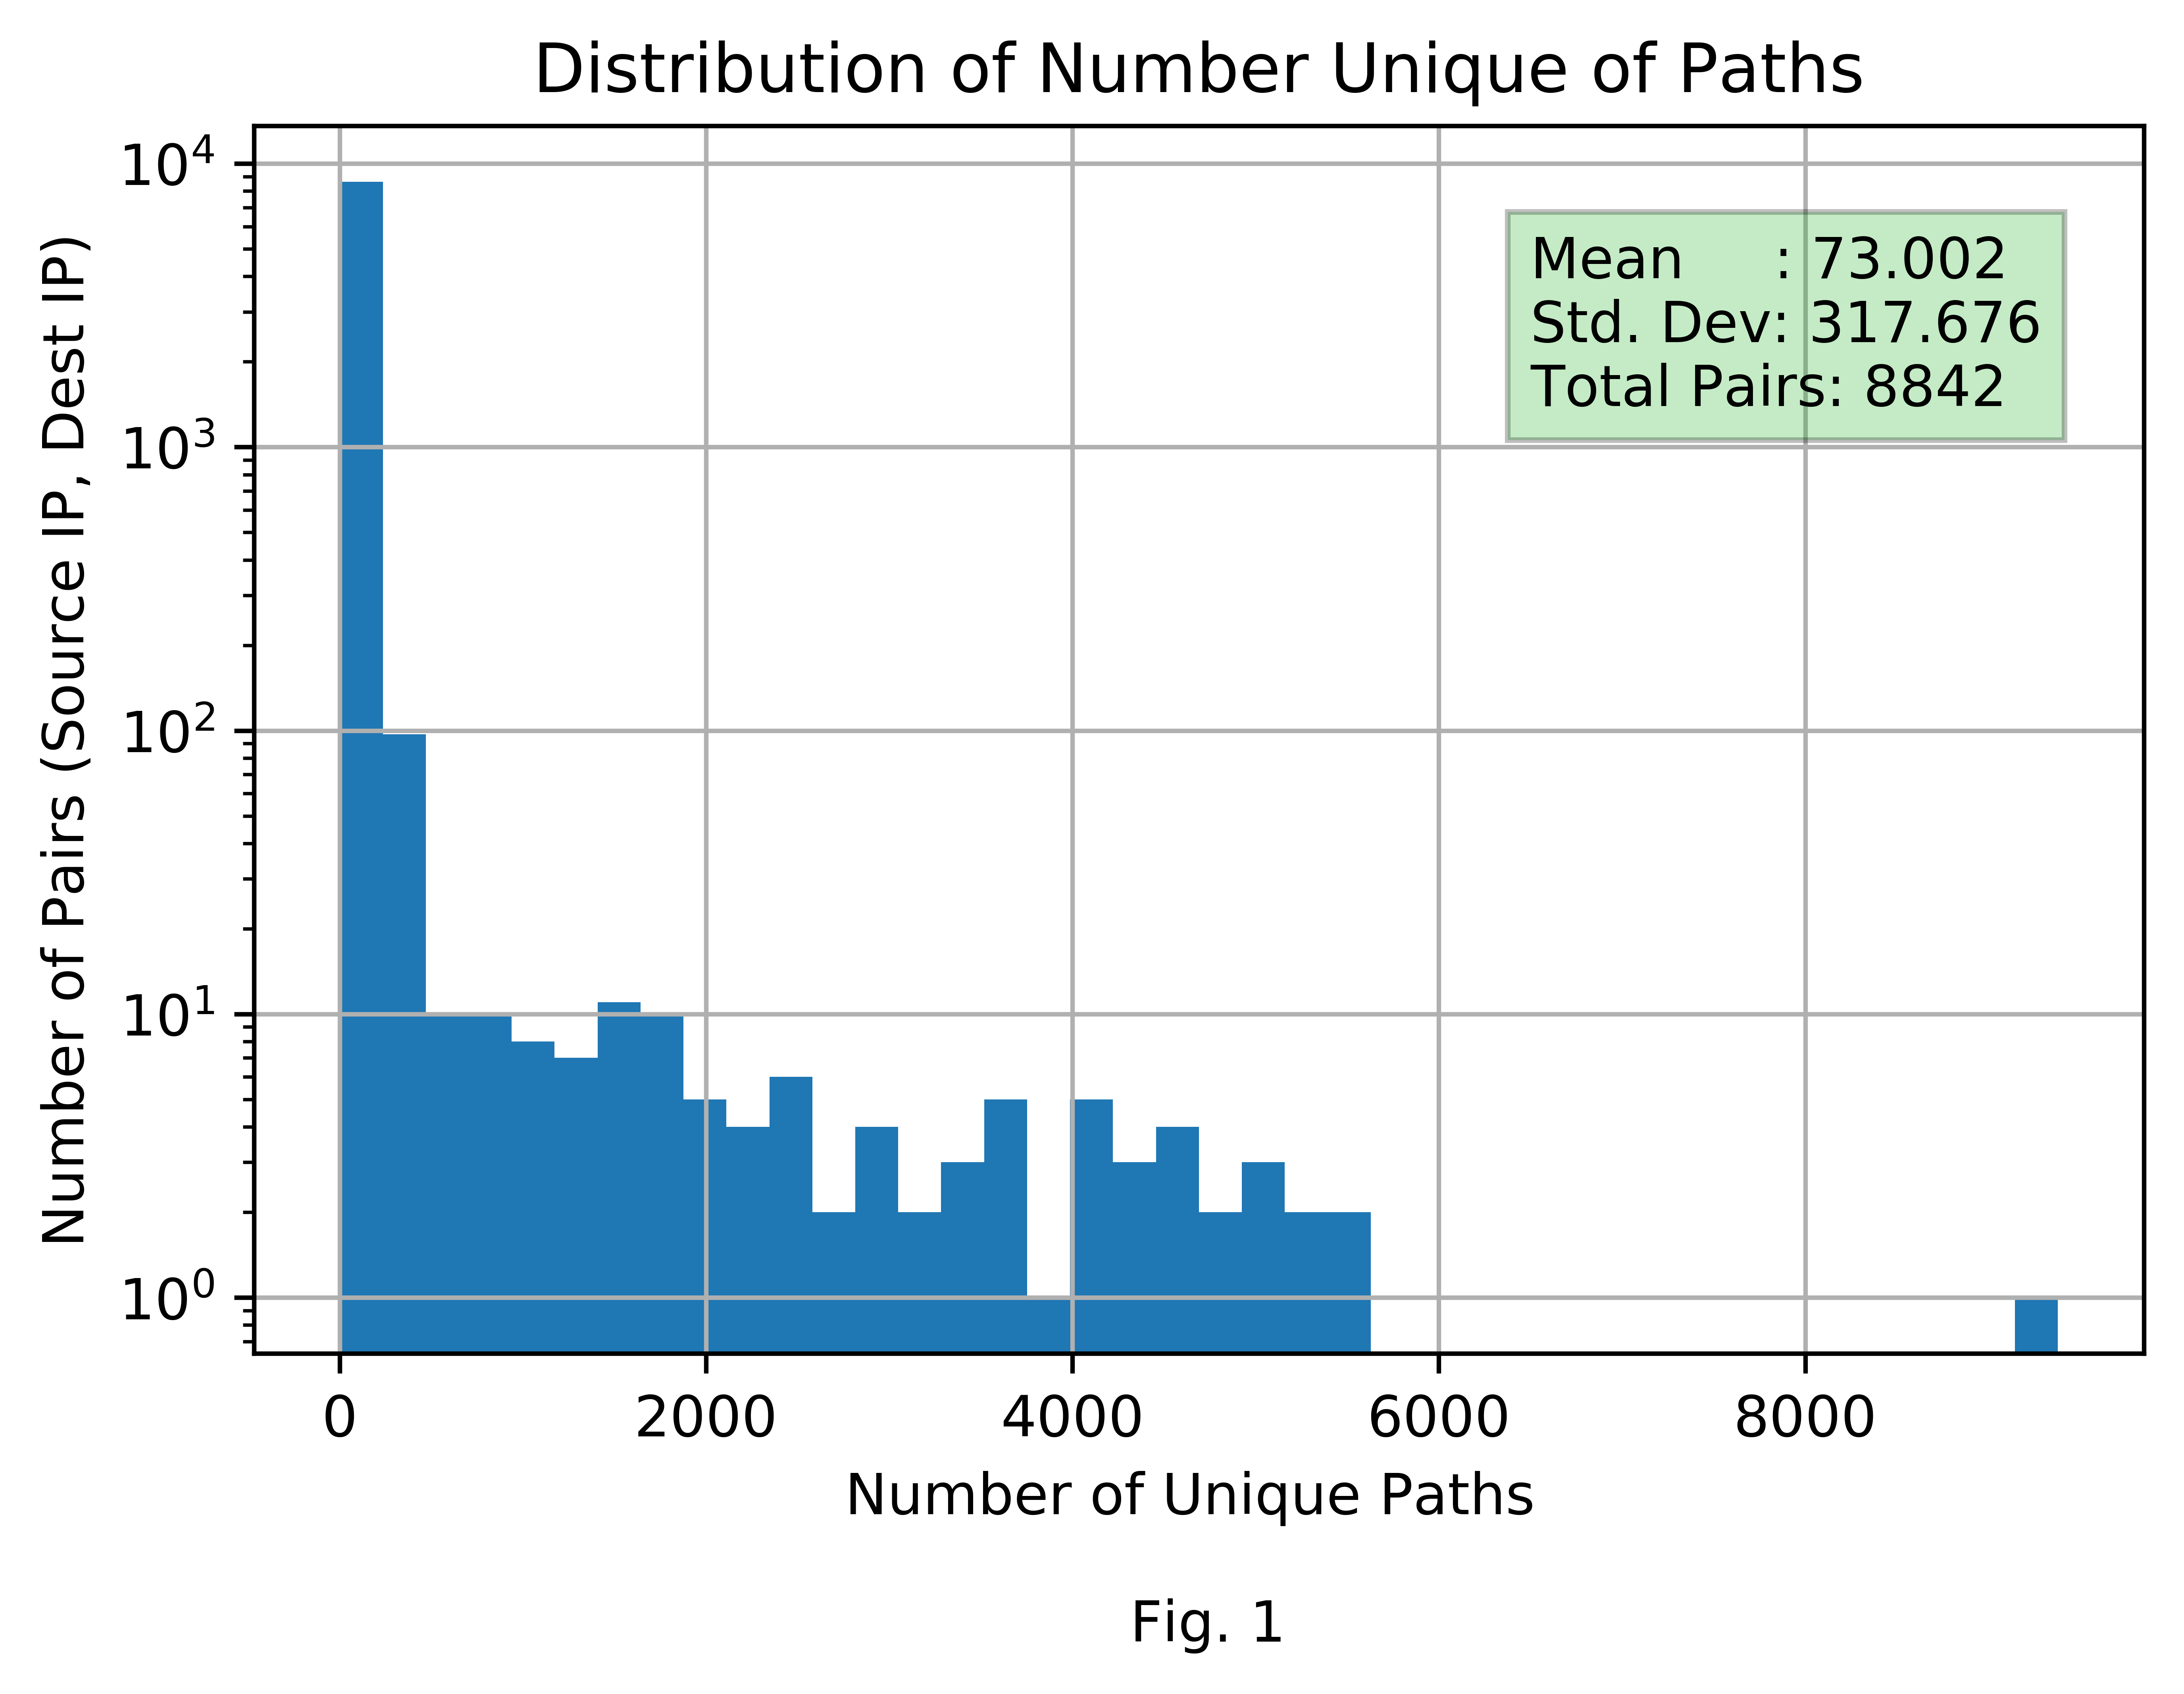

In [22]:
mean_total = src_dest_path_df['Total'].mean()
stddev_total = src_dest_path_df['Total'].std()
legend_data = "Mean     : {:3.3f}\nStd. Dev: {:3.3f}\nTotal Pairs: {:4d}"
plt.figure(dpi=1024)
src_dest_path_df['Total'].hist(bins=40)
plt.title('Distribution of Number Unique of Paths')
plt.xlabel("Number of Unique Paths \n\n Fig. 1")
plt.ylabel("Number of Pairs (Source IP, Dest IP)")
plt.yscale("log")
props = dict(facecolor='xkcd:green', alpha=0.25)
plt.text(6500, 1400, s=legend_data.format(mean_total, stddev_total, src_dest_path_df.shape[0]), bbox=props);

#### Distribution of Paths taken **more than once**

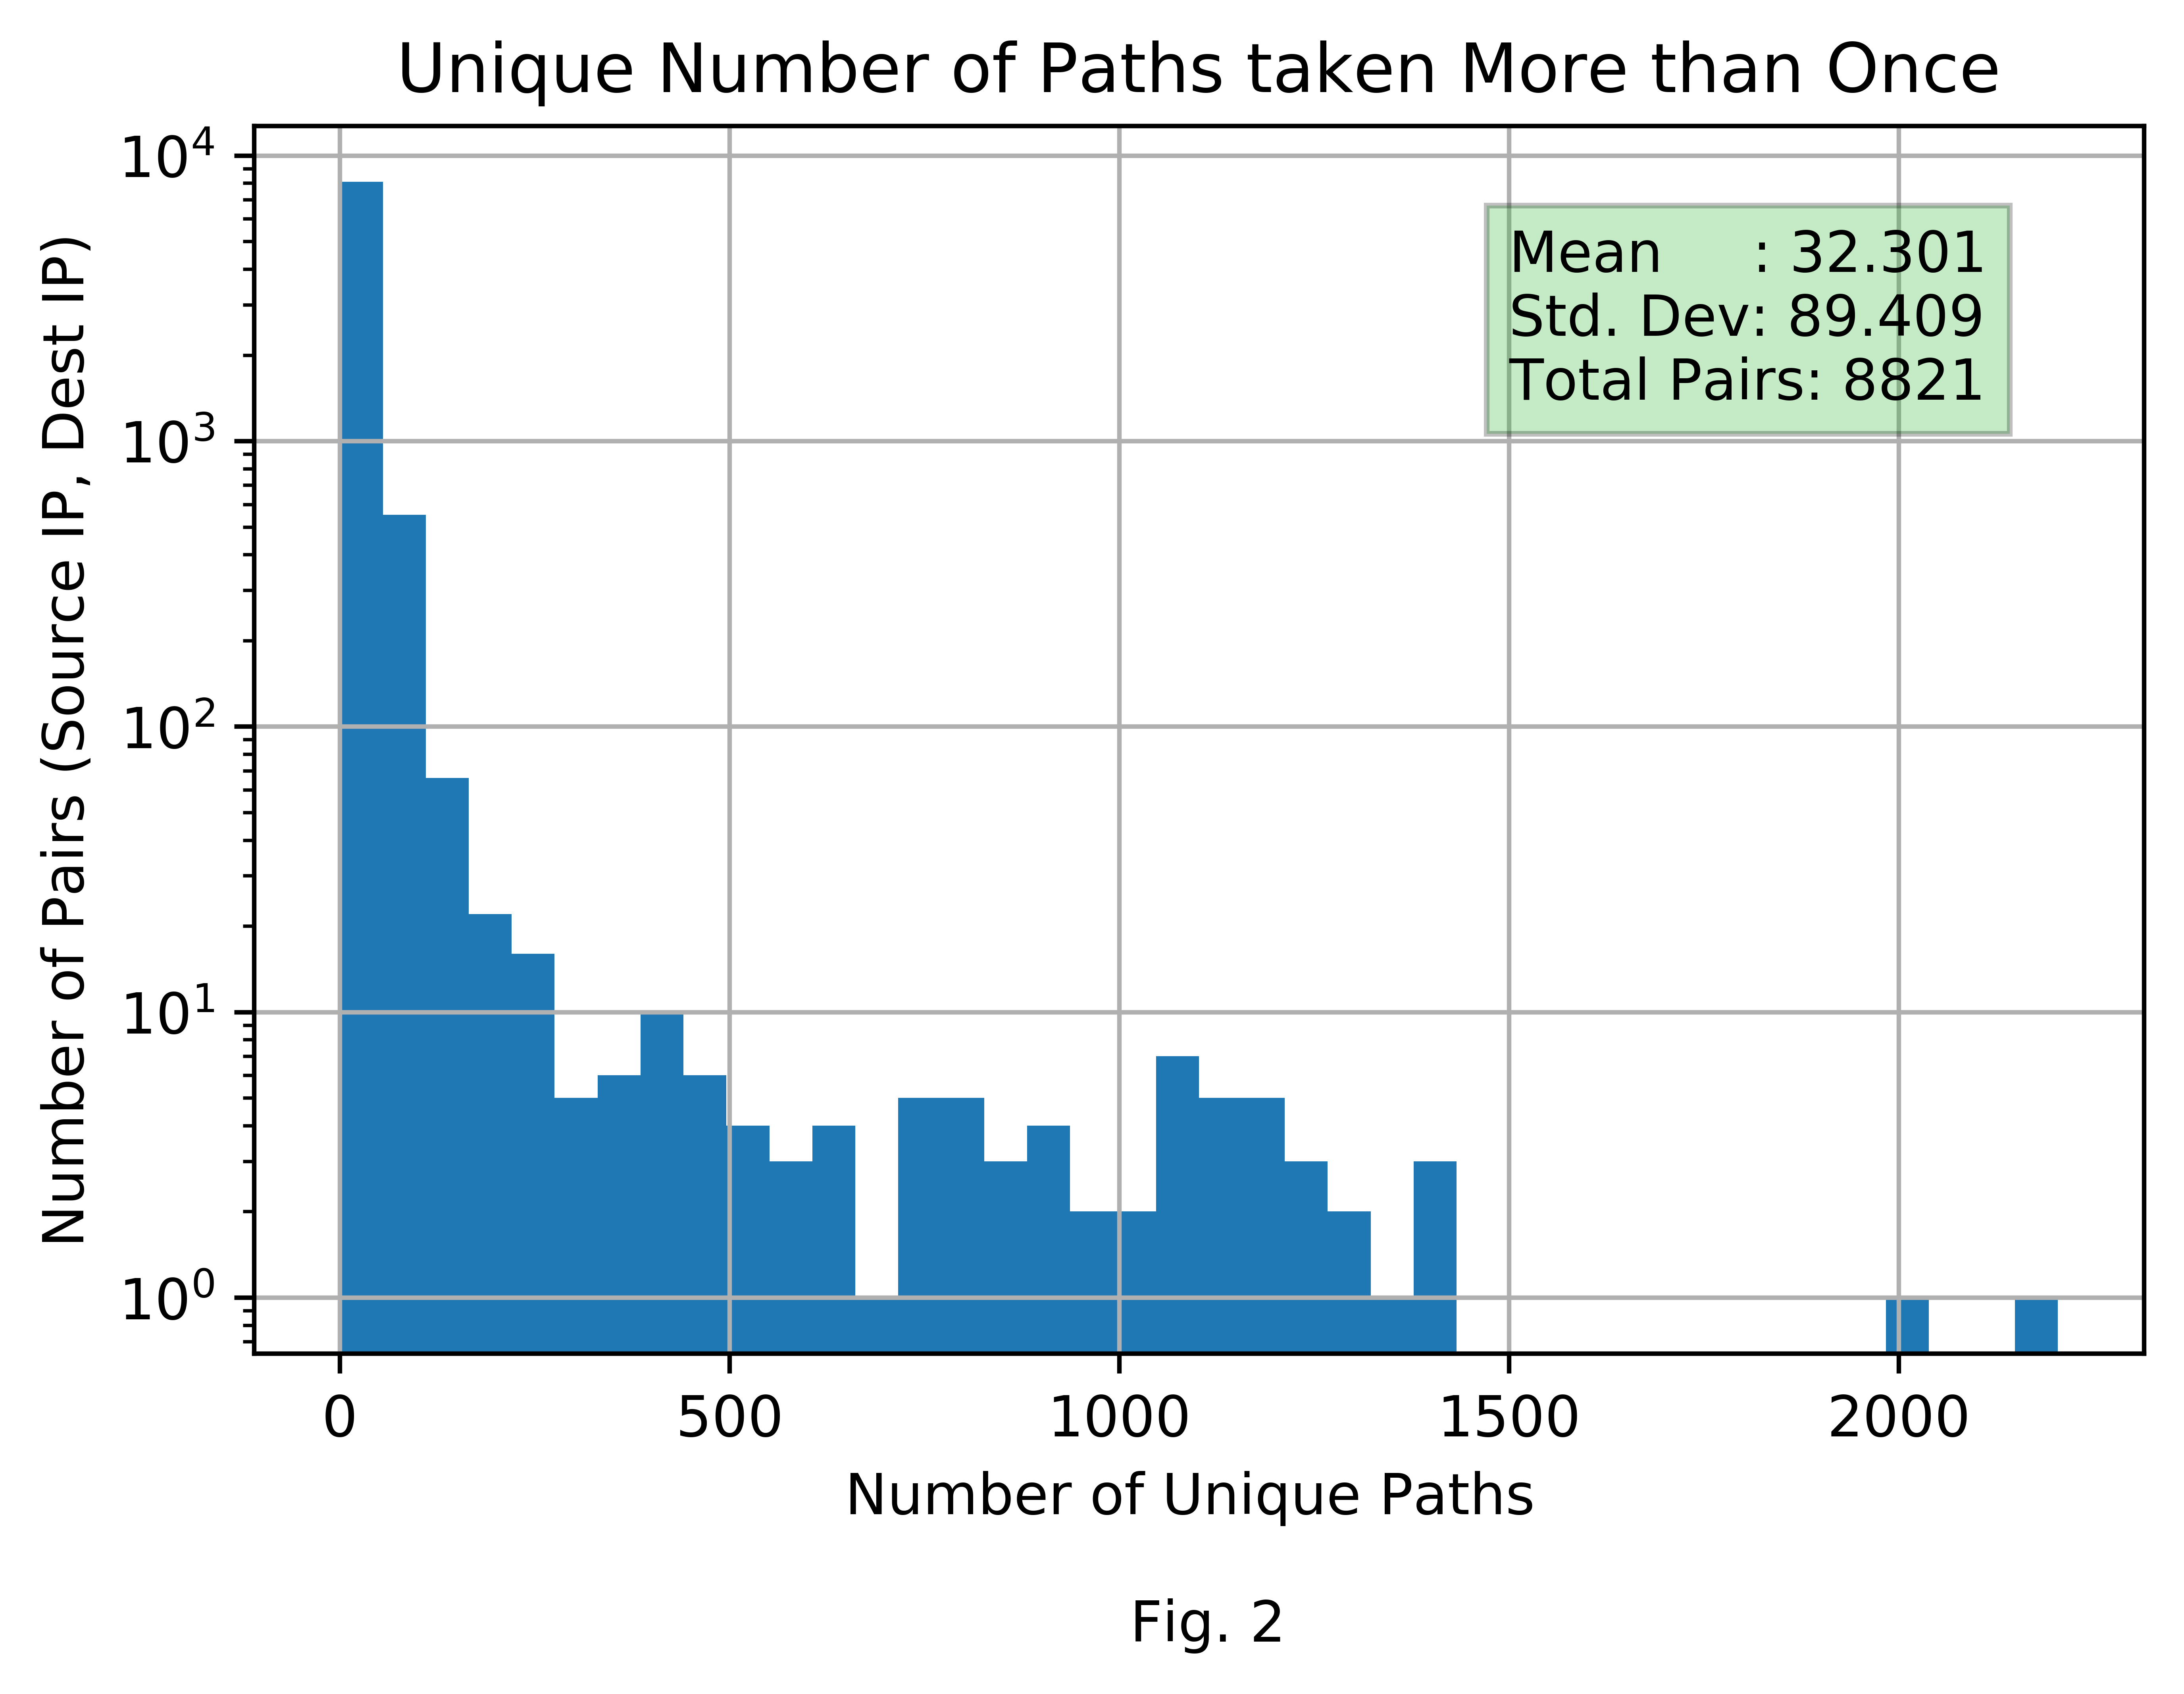

In [23]:
mean = src_dest_path_df['MoreThanOne'].mean()
stddev = src_dest_path_df['MoreThanOne'].std()
legend_data = "Mean     : {:3.3f}\nStd. Dev: {:3.3f}\nTotal Pairs: {:4d}"
plt.figure(dpi=1024)
src_dest_path_df['MoreThanOne'].hist(bins=40)
plt.title('Unique Number of Paths taken More than Once')
plt.xlabel("Number of Unique Paths \n\n Fig. 2")
plt.ylabel("Number of Pairs (Source IP, Dest IP)")
plt.yscale("log")
props = dict(facecolor='xkcd:green', alpha=0.25)
num_pairs = (src_dest_path_df.MoreThanOne >= 1).sum()
plt.text(1500, 1400, s=legend_data.format(mean, stddev, num_pairs), bbox=props);

### *Conclusion*

As we can see here in the distribution of *all* the paths taken, there are quite a few pairs with paths more than 1500. But if we only look at paths which were taken more than once, we see that there are only 3 pairs (most likely outliers) which have more than 1500 paths. This seems like a very interesting finding and can help us in moving forward.

### *Using Neo4j to further investigate the finding above*

We will now ingest data into a locally* hosted Neo4j server, which is a graph database. It also has a nice interface to see the actual graph, which we are most interested in.
To help us with Neo4j we'll use the custom module to move data about the trace hops between a source and destination pair. Which we will randomly sample from all the available pairs.

*The Neo4j needs to be hosted on the machine you're working on, here it is assumed that you're running the notebook locally. If you have an publically hosted Neo4j instance, you can change the link in the NeoInjector constructor and use that.

In [79]:
row = src_dest_path_df.sample(1, random_state=71717)
src = row.iloc[0,0]
dest = row.iloc[0,1]
src, dest

('131.154.254.11', '193.109.172.187')

In [5]:
kibana_usr = None 
kibana_pwd = None
neo_usr = None
neo_pwd = None

with open("creds.key") as f:
    kibana_usr = f.readline().strip()
    kibana_pwd = f.readline().strip()
    neo_usr = f.readline().strip()
    neo_pwd = f.readline().strip()

Connecting to Kibana and Neo4j using Pipeline.

In [6]:
kibana_connect = pipe.KibanaExtractor('atlas-kibana.mwt2.org:9200', kibana_usr, kibana_pwd)
neo_connect = pipe.NeoInjector('bolt://localhost:7687', neo_usr, neo_pwd)

Failed to establish connection to ('127.0.0.1', 7687) (reason [Errno 111] Connection refused)


#### Now we prepare data for transfer to Neo4j

* Getting data for the given Source and Destination.
* Getting unique nodes
* Getting Paths and turning them into pairs (A -> B)


In [ ]:
kibana_connect.getdata(src, dest)
uniq_nodes = kibana_connect.getuniquenodes()
uniq_paths = kibana_connect.get_paths()

errors = 0
error_paths = []
relations = []
for path in uniq_paths:
    for i in range(len(path)-1):
        if path[i] == path[i+1]:
            errors += 1 
            error_paths.append(path)
            break
        relations.append((path[i], path[i+1]))

print("Erronious Paths: {} i.e. there was an hop from an IP to the same IP out of {} unique paths\n".format(errors, len(uniq_paths)))
print("Path Example: {} \n".format(uniq_paths[0]))
print("Relation Example: ", relations[1], "this means that data flows from IP.1 to IP.2")

#### Clearing Neo4j for previous node instances

In [97]:
neo_connect.delete_all()

#### Sending Nodes and Relations to Neo4j

In [98]:
neo_connect.send_nodes_to_neo(uniq_nodes)
neo_connect.send_relations_to_neo(relations)

### Now For Paths taken more than once only

We only have to pass a parameter to the get_paths functon which gets paths taken more than ***k*** number of times

In [ ]:
uniq_paths = kibana_connect.get_paths(k=1)
uniq_nodes = kibana_connect.getuniquenodes()

relations = []
for path in uniq_paths:
    for i in range(len(path)-1):
        if path[i] == path[i+1]:
            print(path)
        relations.append((path[i], path[i+1]))
        
print("Path Example: ", uniq_paths[0])
print("Relation Example: ", relations[1], "this means that data flows from IP.1 to IP.2")

#### Clearing Old Data and Adding New Data

In [ ]:
neo_connect.delete_all()
neo_connect.send_nodes_to_neo(uniq_nodes)
neo_connect.send_relations_to_neo(relations)

#### Closing the Neo4j Connection

In [ ]:
neo_connect.close()

### Conclusion

* *Graph with All Paths Between the above choosen Source and Destination*

![](source_dest_all.png)

* *Graph with Paths taen more than once Between the above choosen Source and Destination*

![](src_dest_one.png)

### Tagging Paths as Stable and Unstable

We consider a paths which happen frequently by time i.e. frequency. So that we remove the hard-threshold of what we did above. And this probably will clean up our data much more because we would even drop paths which are infrequent (or even anomalous) without setting a hard threshold.

In [ ]:
to_time = ut.getDateFormat()
from_time = ut.getDateFormat(delta=90)
pairs = qrs.getSourceDestinationPairs(es, 'ps_derived_trace',to_date = to_time, from_date = from_time)
pairs = pd.DataFrame(pairs)
pairs.head()

In [16]:
def consumeIter(iterator, n = None):
    "Advance the iterator n-steps ahead. If n is None, consume entirely."
    # Use functions that consume iterators at C speed.
    if n is None:
        # feed the entire iterator into a zero-length deque
        collections.deque(iterator, maxlen=0)
    else:
        # advance to the empty slice starting at position n
        next(islice(iterator, n, n), None)
    
def markStablePairPaths(es, src, dest, path_dict, threshold):
    """
    Marks a single pair paths stable/unstable
    
    Args:
        es: ElasticSearch object
        src: Source IP
        dest: dest IP
        path_dict: Dictionary of the paths between the pair. [Results will be stored in this dict only]
        threshold: Amount of Consequetive reading to consider a path stable
    
    Returns:
        None
    
    """
    query = {
        "_source":['hash', 'timestamp'],
        "size":9999,
        "query":{
            "bool":{
                "must":[
                    {"term":{"complete":{"value":1}}},
                    {"term":{"src":{"value":src}}},
                    {"term":{"dest":{"value":dest}}}
                ]
            }
        }
    }
    
    
    times = []
    paths = []

    is_page = 0
    while is_page == 0:
        try:
            page = es.search(index = 'ps_derived_complete_traces', body = query, scroll='1s', size=1000)
            is_page = 1
        except:
            print("Error in retreiving timestamp data for the pair, retrying !:")
            sleep(0.1)
    
    sid = page['_scroll_id']
    scroll_size = page['hits']['total']['value']
    
    while scroll_size > 0:
        for res in page['hits']['hits']:
            times.append(res['_source']['timestamp'])
            paths.append(res['_source']['hash'])
        is_page = 0
        while is_page == 0:
            try:
                page = es.scroll(scroll_id = sid, scroll='1s')
                is_page = 1 
            except:
                print("Error in retreiving timestamp data for the pair, retrying !:")
                sleep(0.1)
        sid = page['_scroll_id']
        scroll_size = len(page['hits']['hits'])
    
    es.clear_scroll(body= {'scroll_id':sid})
    data_frame = pd.DataFrame({"Time":times, "Path":paths}).sort_values(by=['Time'])
    data_iterator = iter(range(data_frame.shape[0]-threshold))
    for indx in data_iterator:
        flag = 0
        if path_dict.get(data_frame.iloc[indx,1]) != 1:
            for i in range(indx,indx+threshold-1):
                if data_frame.iloc[i,1] != data_frame.iloc[i+1,1]:
                    flag = 1
                    break
            if flag == 0:
                path_dict[data_frame.iloc[indx,1]] = 1
                consumeIter(data_iterator, threshold)

In [18]:
def markStable(args):   
    """
    Marks paths between pairs as stable or unstable
    
    Args:
        pairs : Pandas df contaning columns containing src and dest
        threshold : Amount of readings per hour
    
    Returns:
        List of Dictionaries of type:
        {
            "source":<SRC>,
            "destination":<DEST>,
            "paths":{P1:1, P2:0 .... Pn:1}
        }
    """
    
    pair, threshold, thread_id = args[0], args[1], args[2]
    print("Thread : {} , Processing: {} Pairs".format(thread_id, pair.shape[0]))
    paths_stability = []
    
    start_time = time()
    for indx in range(pair.shape[0]):
        temp_res = {
            "source":pair.iloc[indx,0],
            "destination":pair.iloc[indx,1],
            "path_dict":{}
        }
        p_dict_t = qrs.getPathCounts(es, pair.iloc[indx,0], pair.iloc[indx,1], from_time, to_time)
        p_dict= {path['key']:0 for path in p_dict_t}
        
        markStablePairPaths(es, pair.iloc[indx,0], pair.iloc[indx,1], path_dict=p_dict, threshold=threshold)
        
        temp_res['path_dict'] = p_dict
        paths_stability.append(temp_res)
        
        if indx % 25 == 0:
            mins, secs = divmod(time()-start_time, 60)
            print("Thread : {} | Processed : {} pairs | Elapsed: {}m {}s".format(thread_id, indx, mins, secs))
        

    return paths_stability

### Processing all the Pairs in parallel
Otherwise it will more than 6 hours.

In [ ]:
THRESHOLD = 5
n_threads = mp.cpu_count() - 1
pair_pieces = np.array_split(pairs, n_threads)

pool = mp.Pool(n_threads)
results = pool.map(markStable, [[pair_pieces[i], THRESHOLD, i+1] for i in range(n_threads)])

pool.close()
pool.join()


Combining the results

In [ ]:
result = []
for r in results:
    result += r

Saving the result as a Pickled object

In [ ]:
with open("Results_Threshold_{}.pickle".format(THRESHOLD), 'wb') as f:
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)

### Loading the Results (generated via the previous cells)

In [30]:
def load_res(pickle_file_name):
    # Reading in the Pickle Result file
    with open(pickle_file_name,"rb") as f:
        path_res = pickle.load(f)
    
    pair_count = 0
    # Creating an array of Path Counts 
    path_counts_pairwise = []
    for res in path_res:
        tmp_sum = 0
        for key in res['path_dict']:
            tmp_sum += res['path_dict'][key]
        if tmp_sum > 0:
            pair_count += 1

        path_counts_pairwise.append(tmp_sum)
    
    return path_counts_pairwise, pair_count

### Plotting the Results

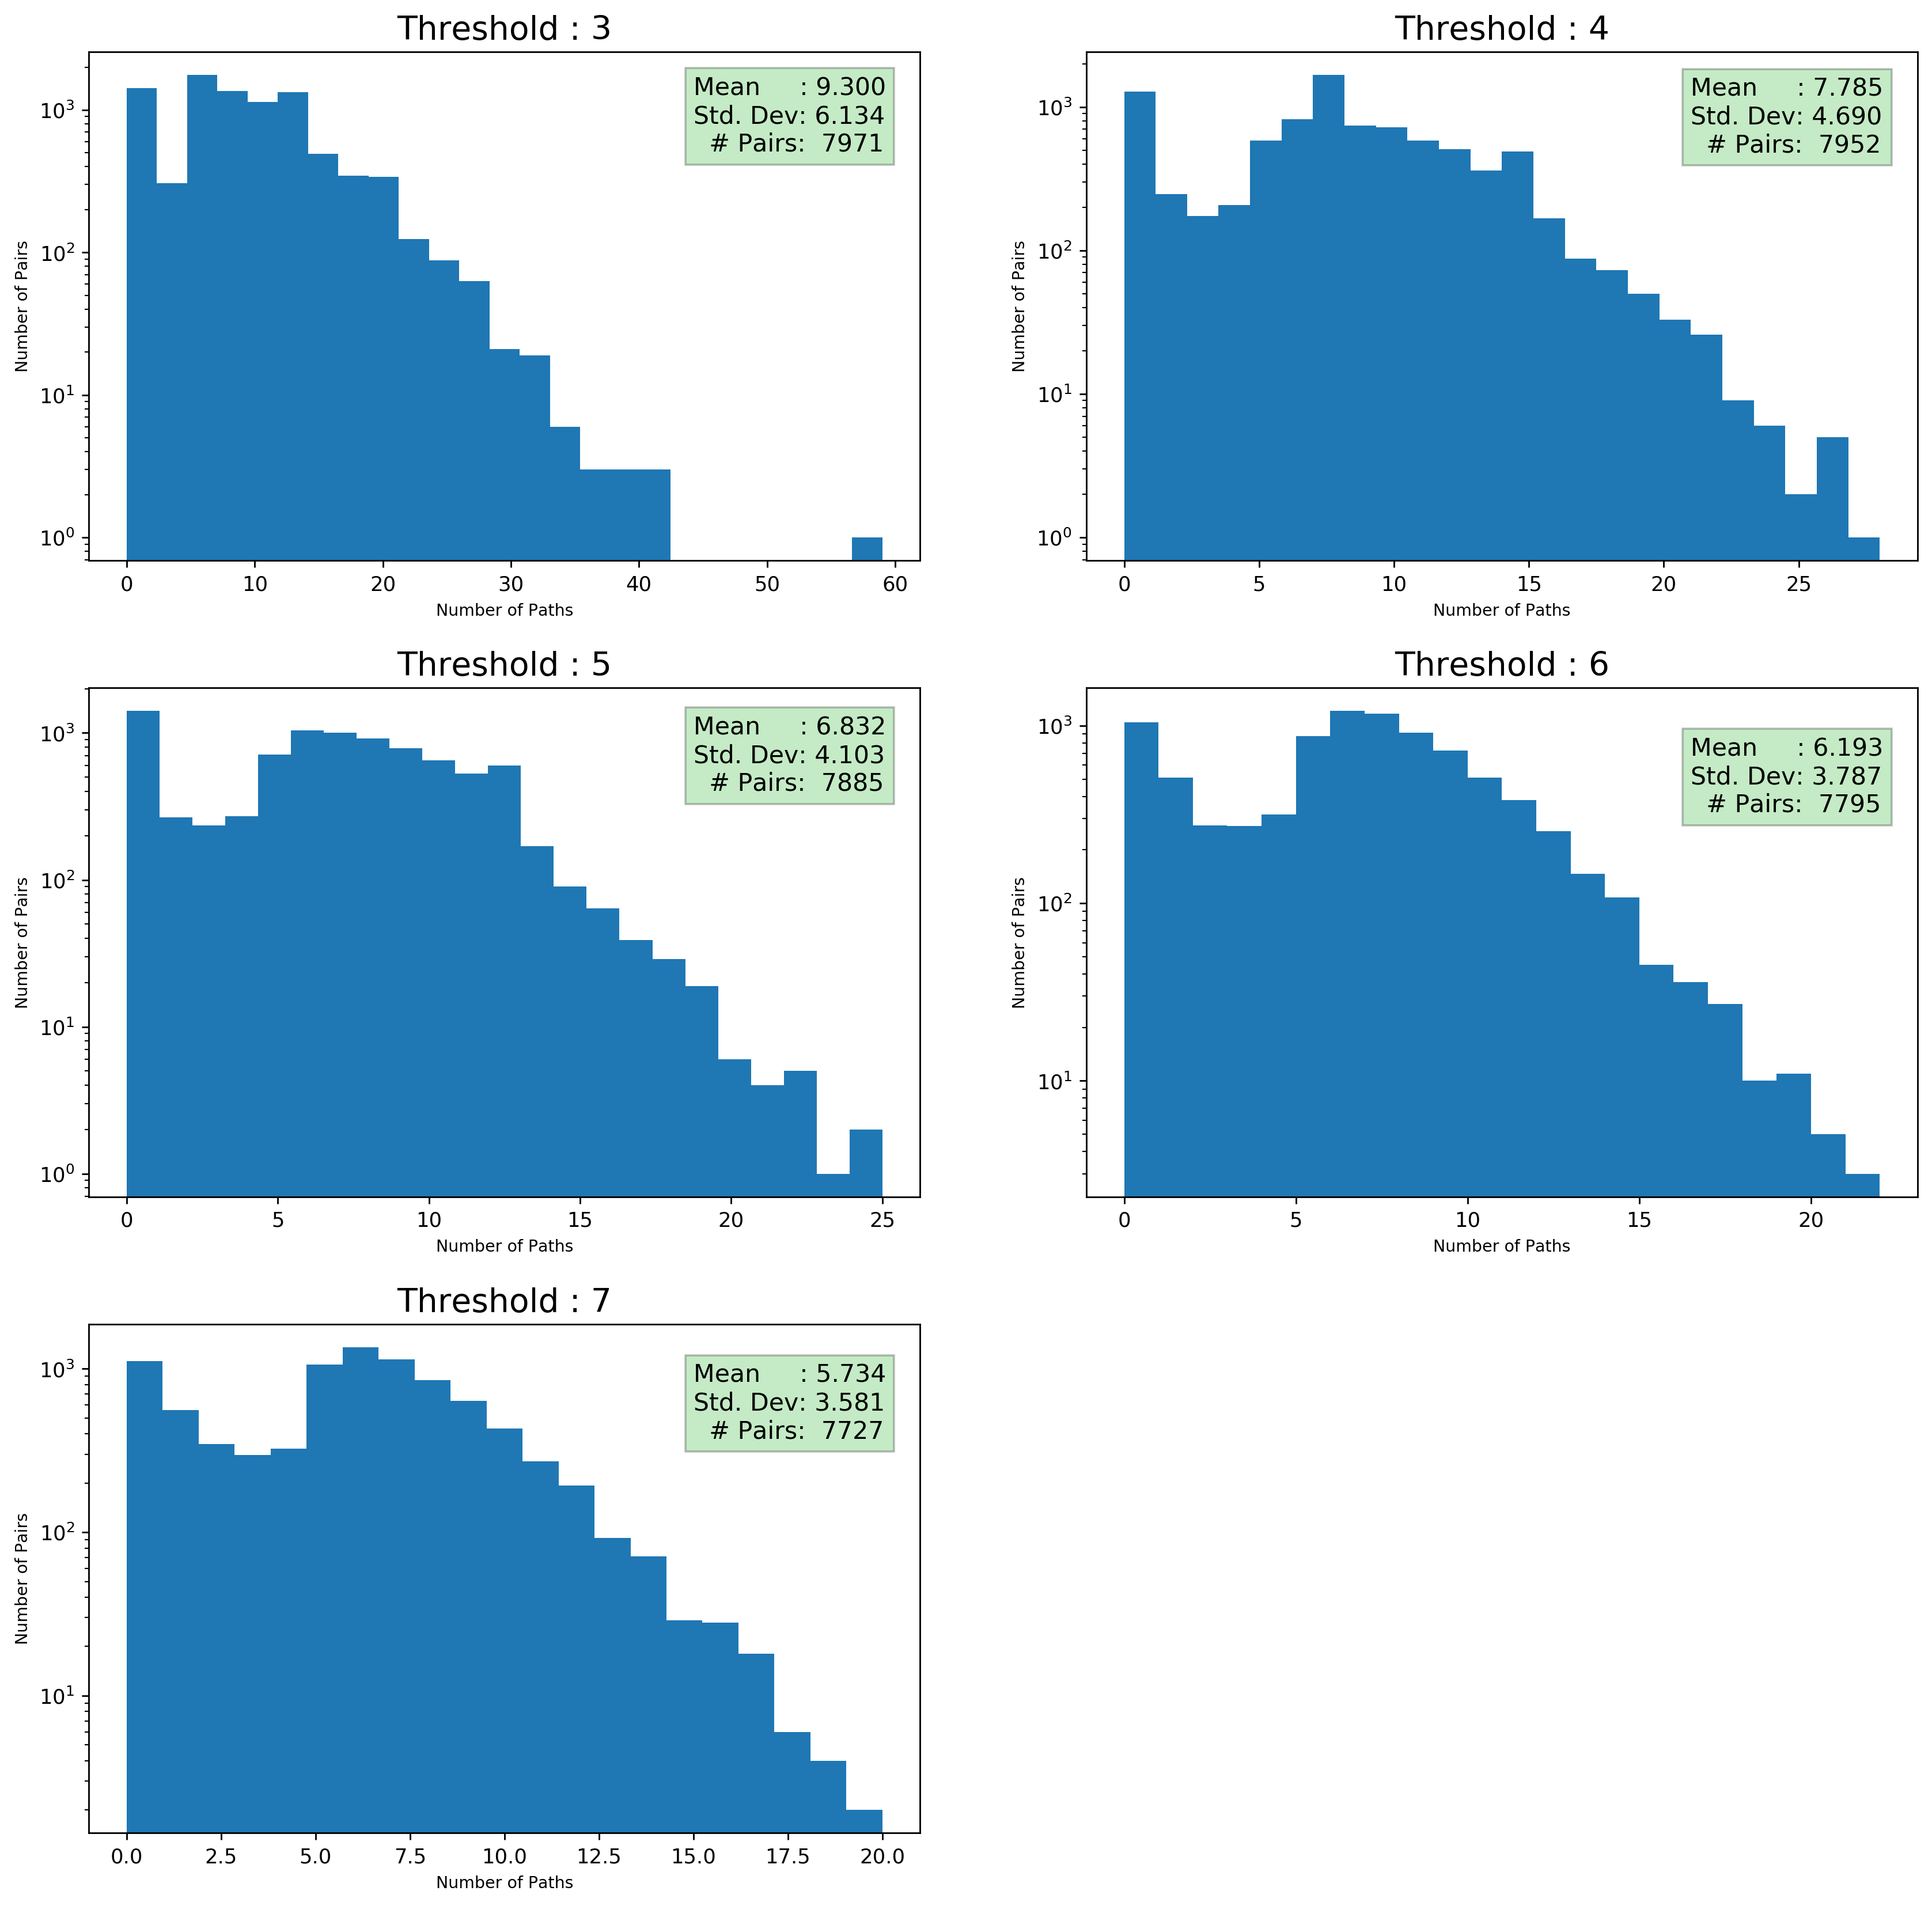

In [9]:
fig, axes = plt.subplots(3, 2, dpi=256, figsize = (16,16))
plt.subplots_adjust(wspace = 0.2, hspace=0.25)
fig.delaxes(axes[2,1])

axes = axes.ravel()[0:-1]
for i,ax in enumerate(axes):
    data, num_pairs = load_res("Results/Results_Threshold_{}.pickle".format(i+3))
    mean = np.mean(data)
    stddev = np.std(data)
    legend_data = "Mean     : {:3.3f}\nStd. Dev: {:3.3f}\n  # Pairs: {:5d}"
    ax.hist(data, bins=25-i)
    ax.set_title('Threshold : {}'.format(i+3), fontsize=16)
    ax.set_xlabel("Number of Paths", fontsize=8)
    ax.set_ylabel("Number of Pairs", fontsize=8)
    ax.set_yscale("log")
    xmin, xmax, ymin, ymax = ax.axis()
    props = dict(facecolor='xkcd:green', alpha=0.25)
    ax.text(xmax/1.4, ymax/5, s=legend_data.format(mean, stddev, num_pairs), bbox=props, fontsize=12);


#### Comparitive Plot of the Histograms Above

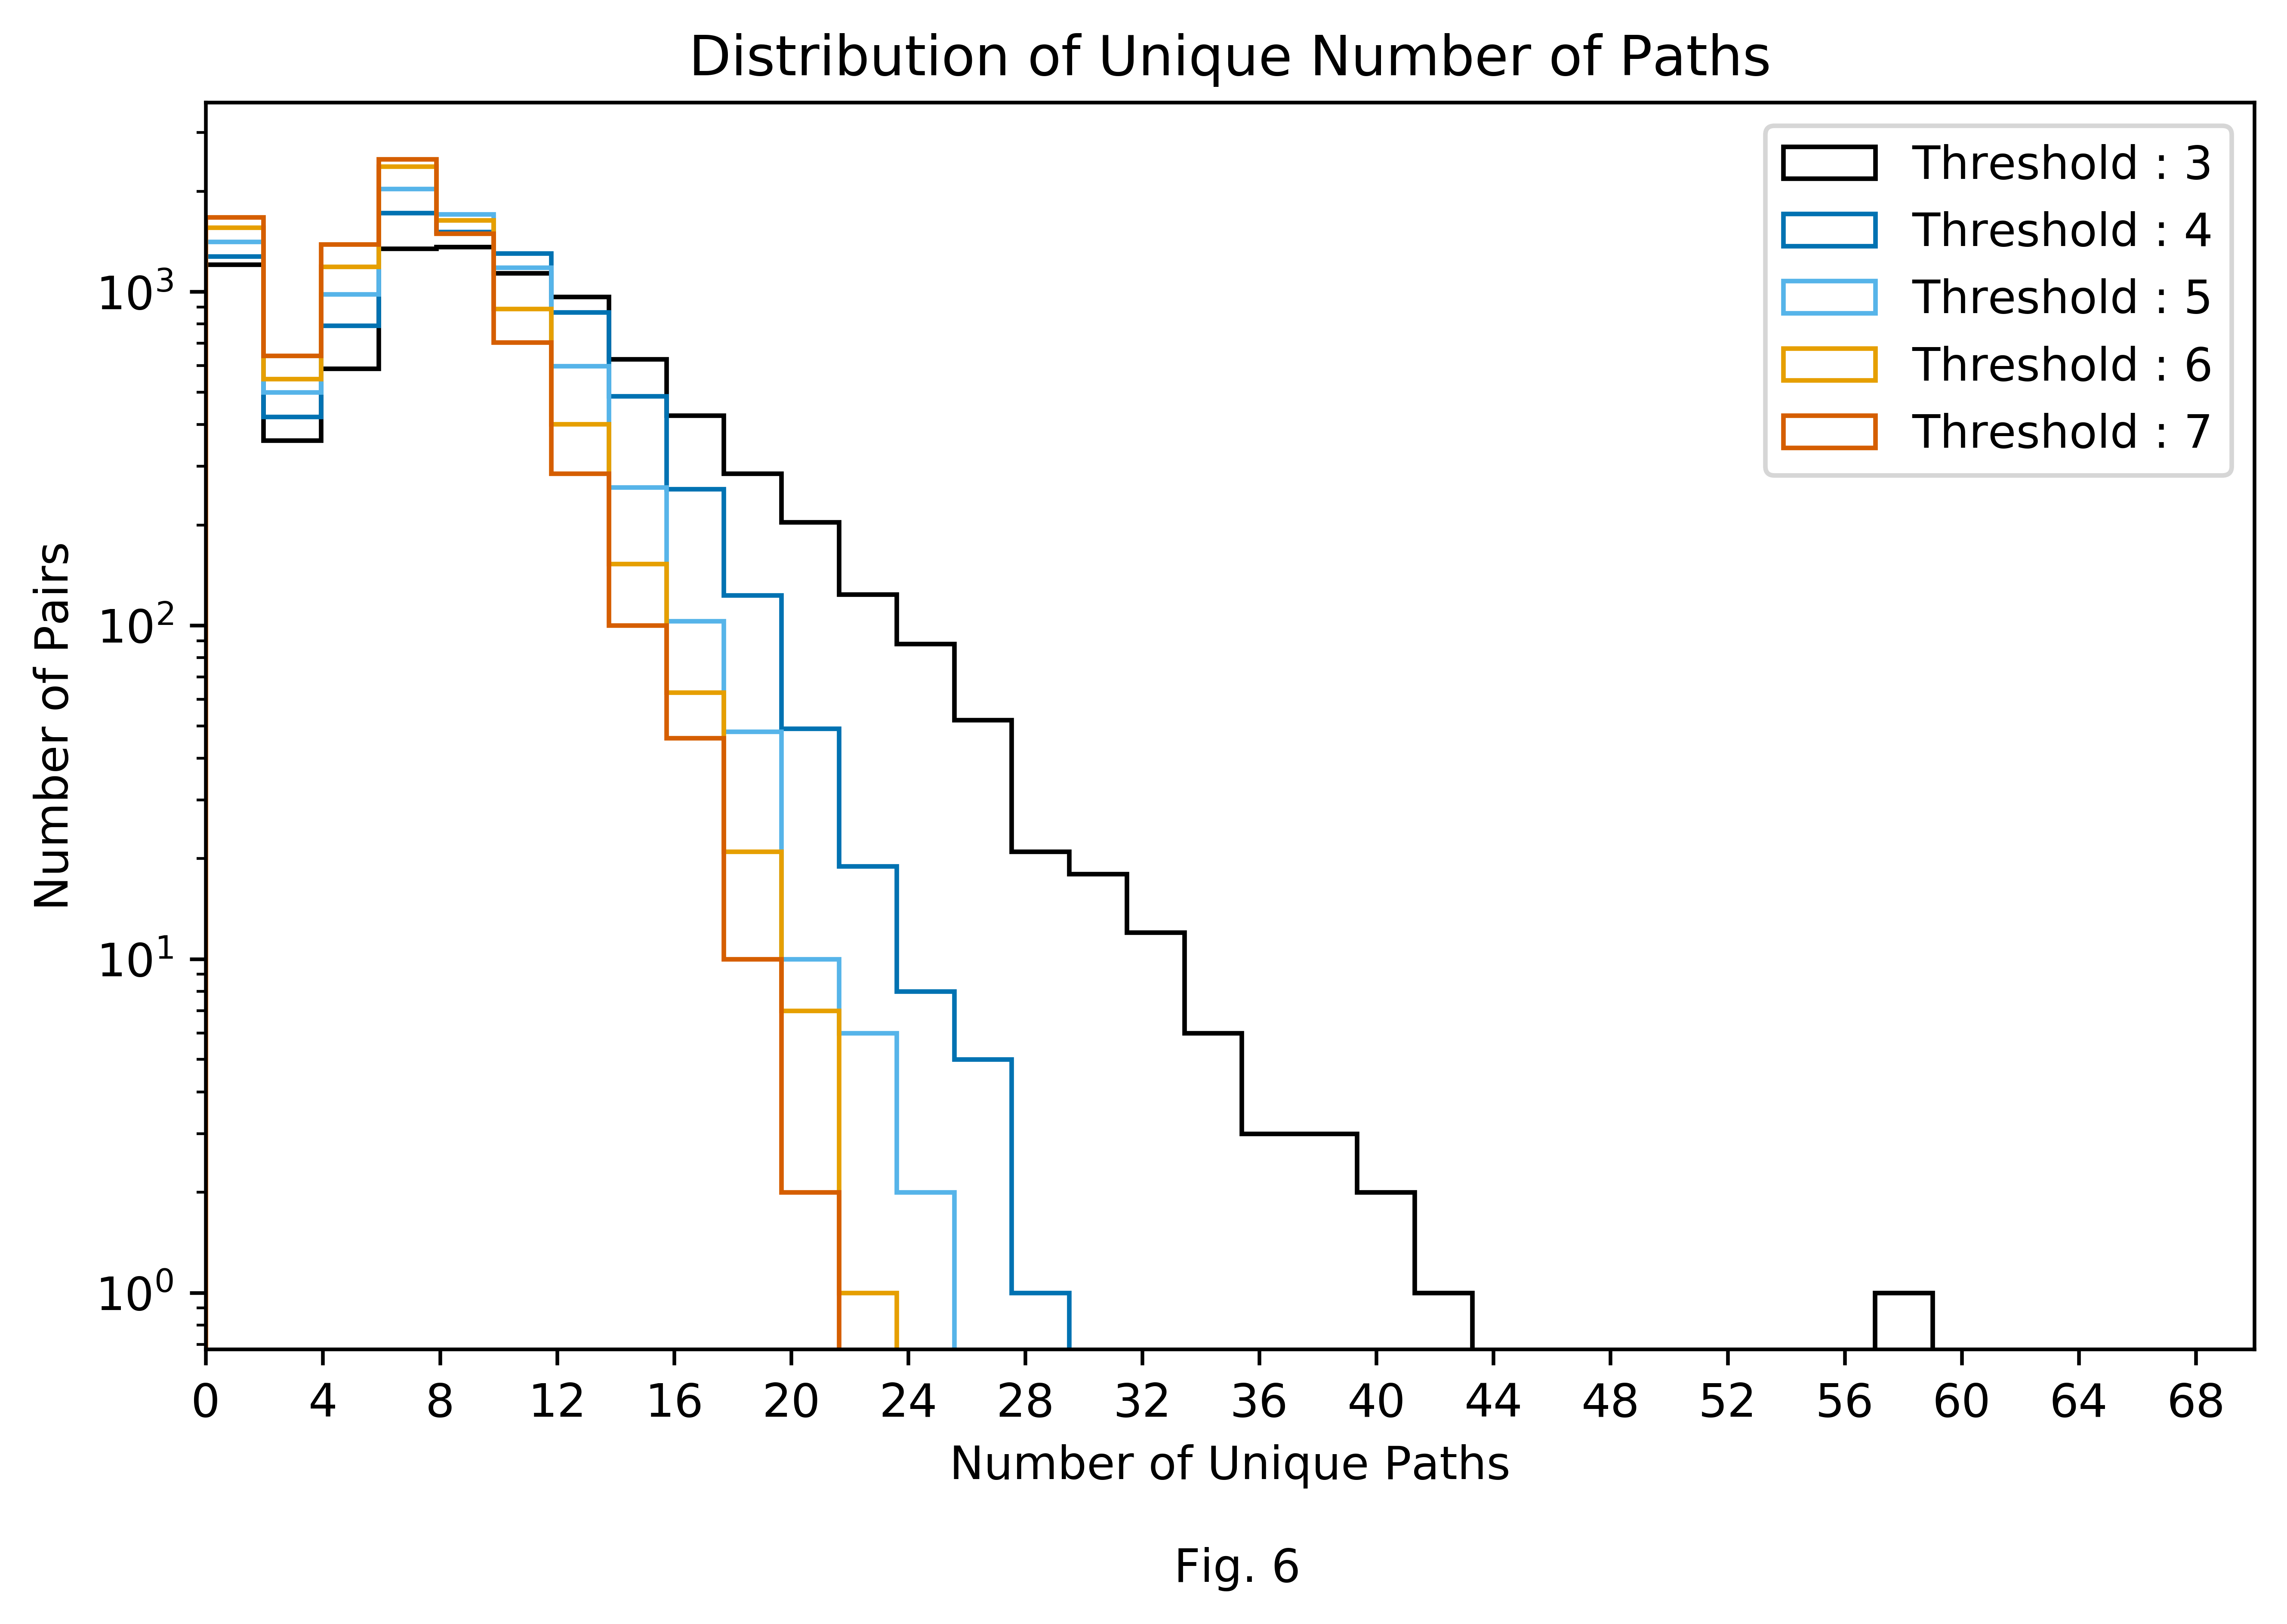

In [35]:
fig, ax = plt.subplots(figsize=(8,5),dpi=768)
ax.set_xlim([0, 70])
means = []
stddevs = []
datas = []
numpairs = []
for i in range(7,2,-1):
    data, num_pairs = load_res("Results/Results_Threshold_{}.pickle".format(i))
    numpairs.append(num_pairs)
    means.append(np.mean(data))
    stddevs.append(np.std(data))
    datas.append(data)

n, bins, patches = plt.hist(datas, 30, histtype='step', stacked=False, fill=False, 
         color = ['#D55E00', '#E69F00', '#56B4E9','#0072B2', '#000000'])
plt.xticks(range(0,70,4))
plt.yticks(range(0, 3000, 250))
plt.yscale('log')
plt.xlabel('Number of Unique Paths\n\n Fig. 6')
plt.ylabel('Number of Pairs')
plt.title('Distribution of Unique Number of Paths')
plt.legend(['Threshold : {}'.format(i) for i in range(3,8)])

#### Mean vs Threshold

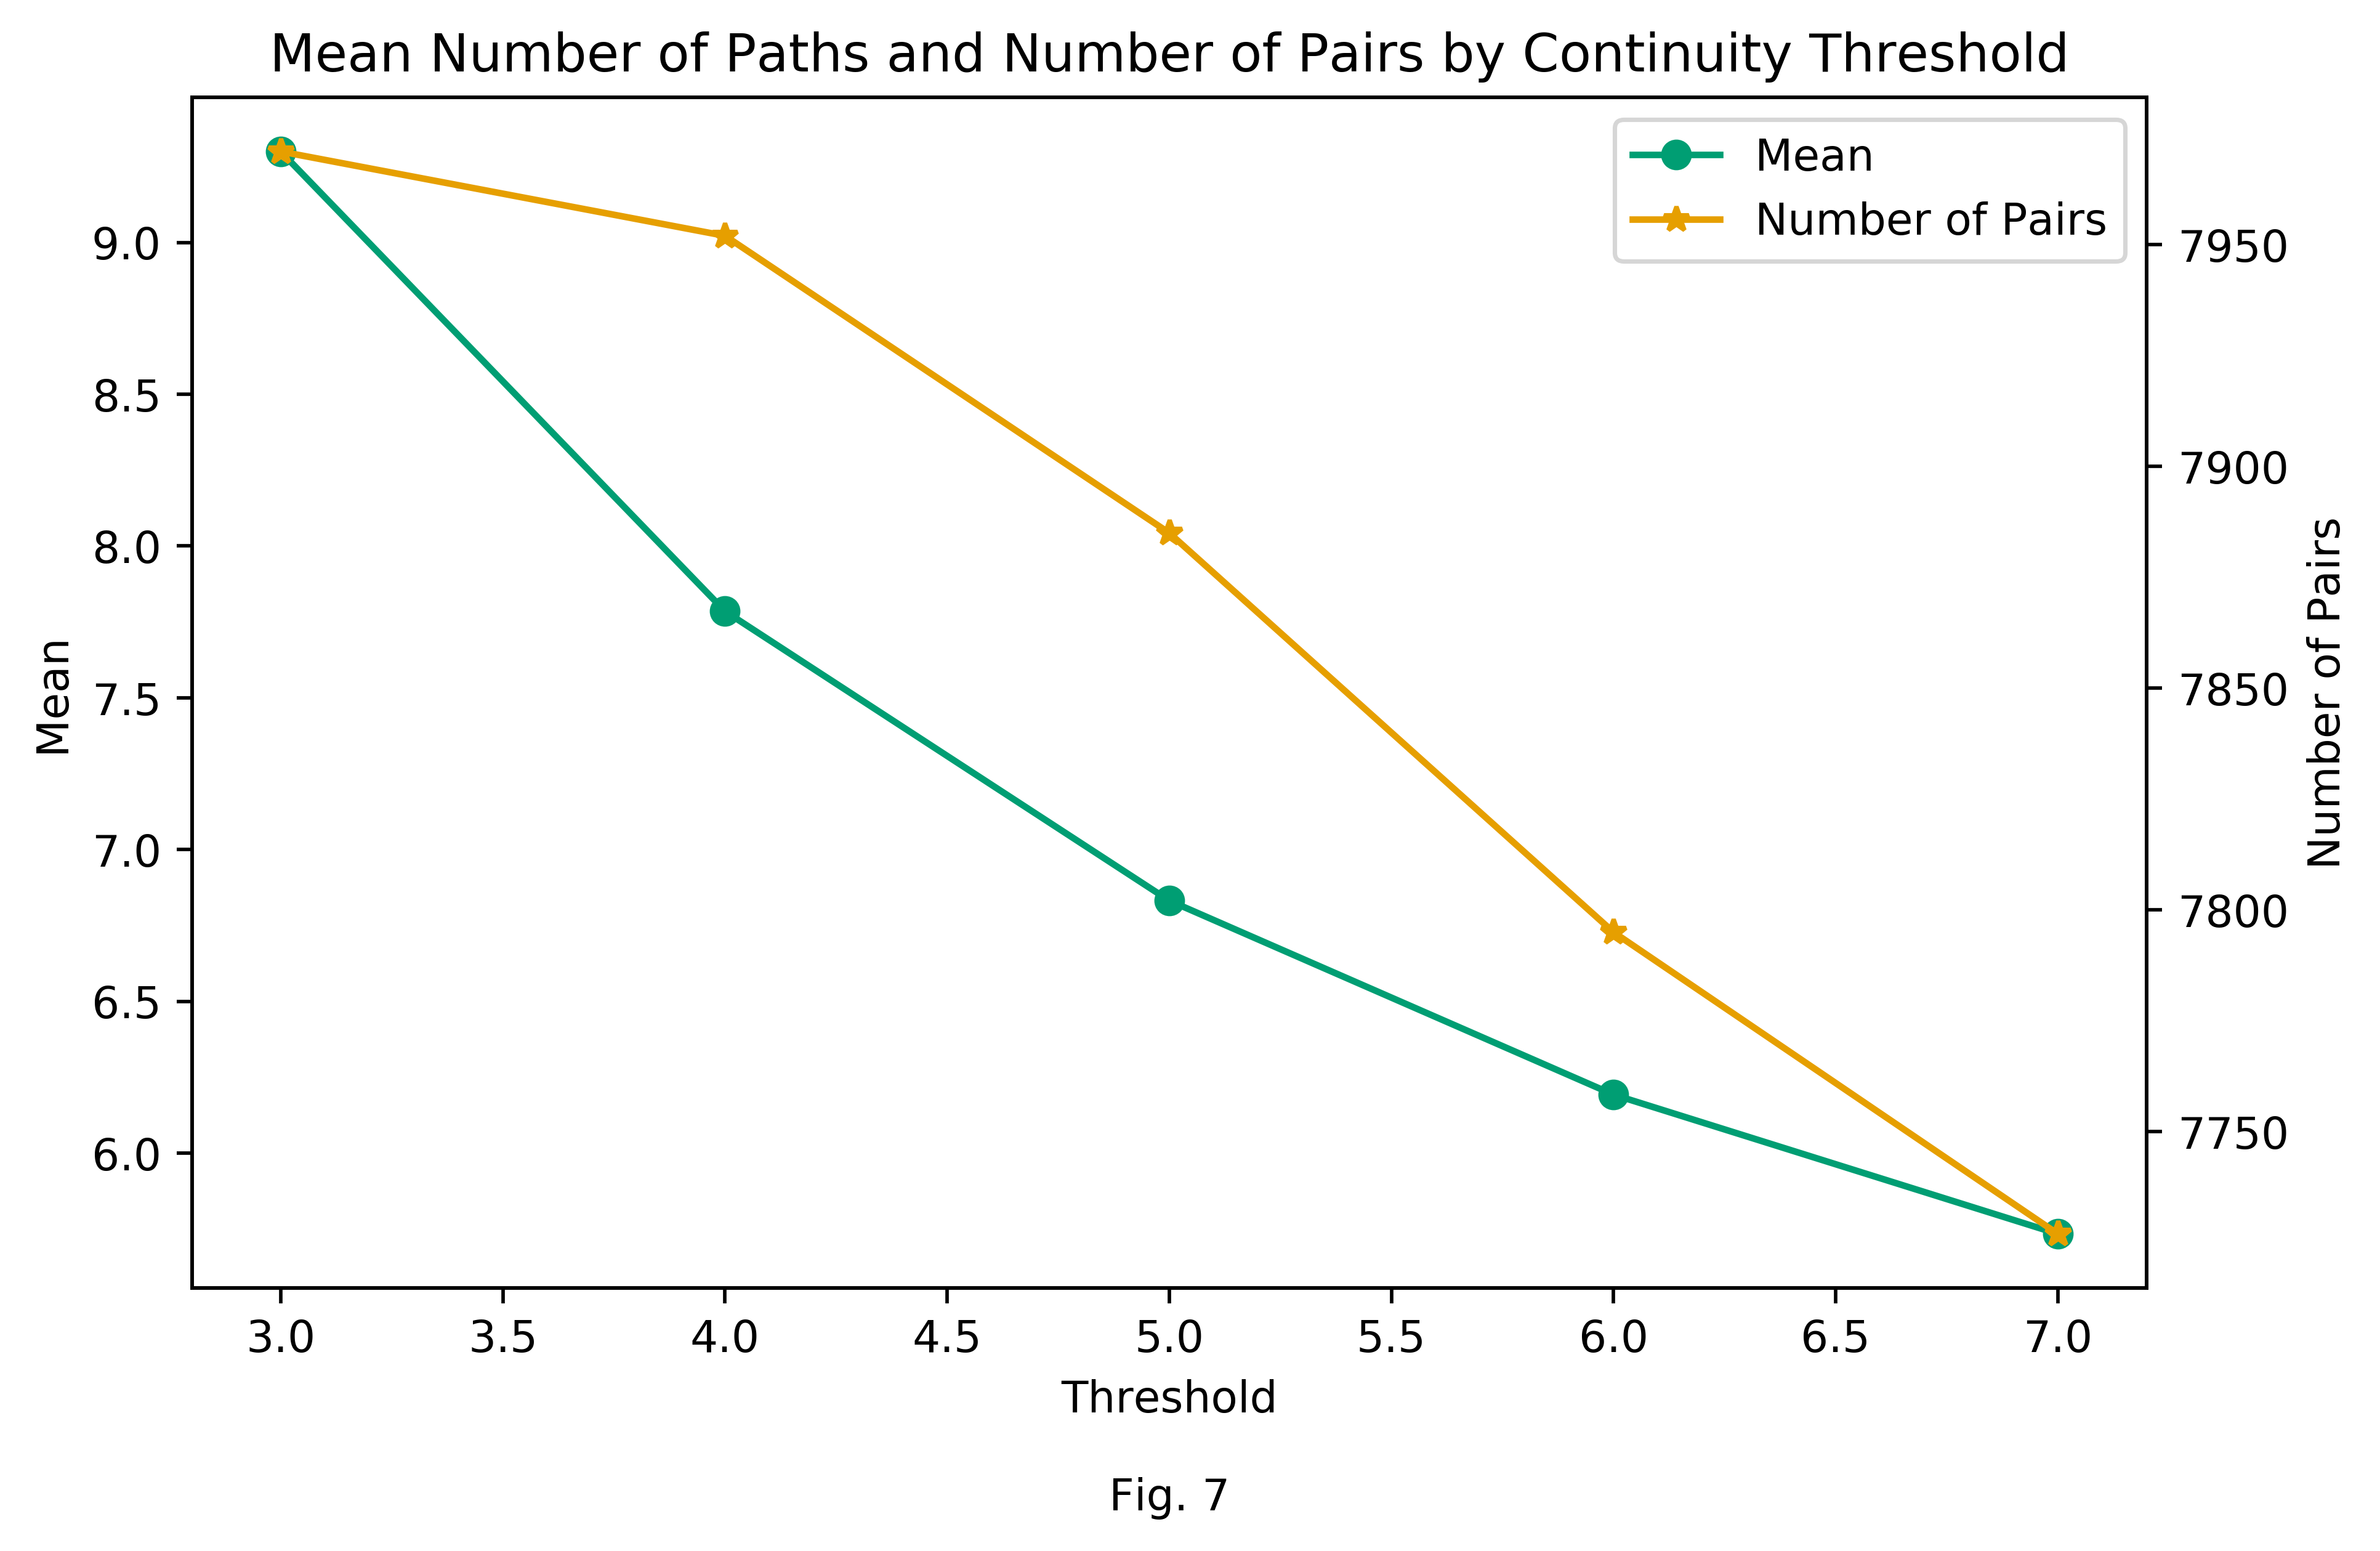

In [32]:
fig, ax = plt.subplots(figsize=(8,5), dpi=512)
xlim = [i for i in range(7,2,-1)]
ax.set_ylabel('Mean')
ax.set_xlabel('Threshold\n\nFig. 7')
ax.plot(xlim ,means, label = 'Mean', c = '#009E73', marker = 'o')
ax_sub = ax.twinx()
ax_sub.set_ylabel('Number of Pairs')
ax_sub.plot(xlim, numpairs, label = 'Number of Pairs', c = '#E69F00', marker = '*')
plt.title('Mean Number of Paths and Number of Pairs by Continuity Threshold')
plt.grid(False)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax_sub.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc=0)

### Outlier Analysis

Here we analyze the pairs, which had extreme characteristics, we will try to answer questions such as why some pairs had abnormally high number of paths, why did we see some circular paths and more ...

In [4]:
with open('Results/Threshold_1.pickle',"rb") as f:
    only_one = pickle.load(f)

SrcDestPairs = {"Source":[], "Destination":[], "Total":[], "MoreThanOne":[]}
for d in only_one:
    SrcDestPairs['Source'].append(d['source'])
    SrcDestPairs['Destination'].append(d['destination'])
    SrcDestPairs['Total'].append(d['total'])
    SrcDestPairs['MoreThanOne'].append(d['topk'])

src_dest_path_df = pd.DataFrame(SrcDestPairs)
src_dest_path_df['Once'] = src_dest_path_df['Total'] - src_dest_path_df['MoreThanOne']
src_dest_path_df.head()

,Source,Destination,Total,MoreThanOne,Once
0,202.140.191.90,109.105.124.88,26,12,14
1,202.140.191.90,131.154.254.11,49,26,23
2,202.140.191.90,193.109.172.187,33,22,11
3,202.140.191.90,206.12.9.1,49,30,19
4,202.140.191.90,193.48.99.77,31,17,14


We now find the pairs with too many paths, we already have some results we can re-use them here to move forward. They were just read above.

In [5]:
max_sorted_pairs = src_dest_path_df.sort_values(['Total'], ascending=False)

In [6]:
max_sorted_pairs.head(5)

,Source,Destination,Total,MoreThanOne,Once
3986,2620:6a:0:8420::44,2001:718:401:6025:1::191,9379,2010,7369
4042,131.225.205.23,131.169.7.30,5604,254,5350
4065,131.225.205.23,148.6.8.252,5518,306,5212
4047,131.225.205.23,193.140.100.130,5317,487,4830
4043,131.225.205.23,193.170.243.214,5264,534,4730


Just for sanity check, we check what we see above is right or not. 

In [16]:
to_time = ut.getDateFormat()
from_time = ut.getDateFormat(delta=90)
src = max_sorted_pairs.iloc[0,0]
dest = max_sorted_pairs.iloc[0,1]
query = {
    "size":0,
    "query":{
        "bool":{
            "must":[
                {"term":{"src":{"value":src}}},
                {"term":{"dest":{"value":dest}}},
                {"term":{"looping":{"value":1}}}
            ]
        }
    },
    "aggs":{
        "hashes":{
            "cardinality":{
                "field":"hash"
            }
        }
    }
}

data = es.search('ps_derived_complete_traces', query)


In [17]:
print("Source: {} \nDestination: {}\nNumber of Unique Paths: {}\n".format(src, dest, data['aggregations']['hashes']['value']))

Source: 2620:6a:0:8420::44 
Destination: 2001:718:401:6025:1::191
Number of Unique Paths: 8570



`Now we check how has our heuristic of continuity worked for the pair we're observing`

In [32]:
for i in range(5):
    with open("Results/Results_threshold_{}.pickle".format(i+3),"rb") as f:
        path_res = pickle.load(f)

    tmp_sum = 0
    for res in path_res:
        for chnks in res:
            if chnks['source'] == src and chnks['destination'] == dest:
                for key in chnks['path_dict']:
                    tmp_sum += chnks['path_dict'][key]
                print("Threshold : {} | Stable Paths: {}".format(i+3, tmp_sum))
                break

Threshold : 3 | Stable Paths: 3
Threshold : 4 | Stable Paths: 2
Threshold : 5 | Stable Paths: 1
Threshold : 6 | Stable Paths: 1
Threshold : 7 | Stable Paths: 1


`Now we'll try to find some pattern using Neo4j.`

In [33]:
kibana_usr = None 
kibana_pwd = None
neo_usr = None
neo_pwd = None

with open("creds.key") as f:
    kibana_usr = f.readline().strip()
    kibana_pwd = f.readline().strip()
    neo_usr = f.readline().strip()
    neo_pwd = f.readline().strip()

Connecting to Kibana and Neo4j using Pipeline.

In [34]:
kibana_connect = pipe.KibanaExtractor('atlas-kibana.mwt2.org:9200', kibana_usr, kibana_pwd)
neo_connect = pipe.NeoInjector('bolt://localhost:7687', neo_usr, neo_pwd)

Failed to establish connection to ('127.0.0.1', 7687) (reason [Errno 111] Connection refused)


#### Now we prepare data for transfer to Neo4j and analysis

* Getting data for the given Source and Destination.
* Getting unique nodes
* Getting Paths and turning them into pairs (A -> B)


In [35]:
kibana_connect.getdata(src, dest)
uniq_nodes = kibana_connect.getuniquenodes()
uniq_paths = kibana_connect.get_paths()

errors = 0
error_paths = []
relations = []
for path in uniq_paths:
    for i in range(len(path)-1):
        if path[i] == path[i+1]:
            errors += 1 
            error_paths.append(path)
            break
        relations.append((path[i], path[i+1]))

print("Erronious Paths: {} i.e. there was an hop from an IP to the same IP out of {} unique paths (self loop)\n".format(errors, len(uniq_paths)))

Erronious Paths: 1521 i.e. there was an hop from an IP to the same IP out of 7164 unique paths



`Storing the Error Paths to disk`, so that we don't have to do it again and again

In [16]:
with open('Results/error_paths_{}_{}.txt'.format(src, dest), 'w') as f:
    for path in error_paths:
        f.write(repr(path)+"\n")

### We will now categorise the data in the past 90-95 days into bins such as paths with loops and incomplete traceroutes

This will help us remove noisy data and help us infer better info from the plots.

In [24]:
"""
Template for the new index
{
    type:doc
    timestamp:xxx,
    source:xxx
    dest:xxx
    traceroute:xxx
    rtt:xxx
    hash:xxx
    looping:xxx (1 if ip's repeat in traceroute else 0)
    complete: (1 if traceroute is complete 0 otherwise)
}

"""

print()

In [4]:
# Saved Time Range
with open("times.txt") as f:
    time_to = float(f.readline().strip())
    time_from = float(f.readline().strip())
time_to, time_from

# Window of size 4 days to process by a processor
window_millis = 4*24*60*60*1000

# Creating Batches of 4 days each in the time range
batches = []
i = 1
while time_from < time_to:
    batches.append((i, time_from, time_from+window_millis))
    time_from += window_millis
    i += 1

In [5]:
def process_row(row):
    looping = 0
    hops_complete = 0 
    if len(set(row['hops'])) < row['n_hops']:
        looping = 1
    if len(row['hops']) and row['hops'][-1] == row['dest']:
        hops_complete = 1
    
    row['looping'] = looping
    row['complete'] = hops_complete
    
    return row

In [15]:
def process_data(params):
    
    thread_id = params[0]
    time_from = params[1]
    time_to = params[2]
    
    query = {
        "_source":['timestamp','src','dest','traceroute','hops','n_hops','rtts','hash'],
        "query":{
            "bool":{
            "must":[
                {"term":{"src_production":{"value":'true'}}},
                {"term":{"dest_production":{"value":'true'}}},
                {"range":{"timestamp":{
                    "lte":str(time_to),
                    "gte":str(time_from),
                    "format":"epoch_millis"
                }}}
            ]
            }
        }
    }
    
    start_time = time()
    is_page = 0
    while is_page == 0:
        try:
            page = es.search(index = 'ps_trace', scroll = '2m', size = 1000, body = query)
            is_page = 1
        except Exception:
            print("Error !, getting page. Retrying")
            sleep(0.01)
            
    sid = page['_scroll_id']
    scroll_size = page['hits']['total']['value']
    print("Batch ID: {} Size: {}".format(thread_id, scroll_size))
    i = 0
    while (scroll_size > 0):
        actions = [process_row(result['_source']) for result in page['hits']['hits']]
        bulk_push = 0
        while bulk_push != 1:
            try:
                bulk(es, actions=actions, index='ps_derived_trace', doc_type='_doc')
                bulk_push = 1
                break
            except Exception as e:
                print("Bulk Push Error, Retrying !", e)
                sleep(0.10)
                break
        is_page = 1
        while is_page == 0:
            try:
                page = es.scroll(scroll_id = sid, scroll = '2m')
                is_page = 1
            except Exception:
                print("Error! Getting Page, Retrying")
                sleep(0.10)
    
        sid = page['_scroll_id']
        scroll_size = len(page['hits']['hits'])
        if i % 50 == 0:
            total_time = time() - start_time
            mins, secs = divmod(total_time, 60)
            print("Thread Id: {:3d} | Iteration: {:3d} |Time Elapsed: {:4.4f}m {:4.4f}s".format(thread_id, i+1, mins, secs))
        
        i += 1
 

In [ ]:
n_threads = len(batches)
pair_pieces = np.array_split(pairs, n_threads)

pool = mp.Pool(n_threads)
results = pool.map(process_data, batches)

pool.close()
pool.join()

### Distribution After Removing Incomplete Traceroutes

In [25]:
with open('Results/Threshold_1_Clean.pickle',"rb") as f:
    only_one = pickle.load(f)

SrcDestPairs = {"Source":[], "Destination":[], "Total":[], "MoreThanOne":[]}
for d in only_one:
    SrcDestPairs['Source'].append(d['source'])
    SrcDestPairs['Destination'].append(d['destination'])
    SrcDestPairs['Total'].append(d['total'])
    SrcDestPairs['MoreThanOne'].append(d['topk'])

src_dest_path_clean_df = pd.DataFrame(SrcDestPairs)
src_dest_path_clean_df['Once'] = src_dest_path_clean_df['Total'] - src_dest_path_clean_df['MoreThanOne']

Text(6500, 1400, 'Mean     : 53.475\nStd. Dev: 263.514\nTotal Pairs: 8842')

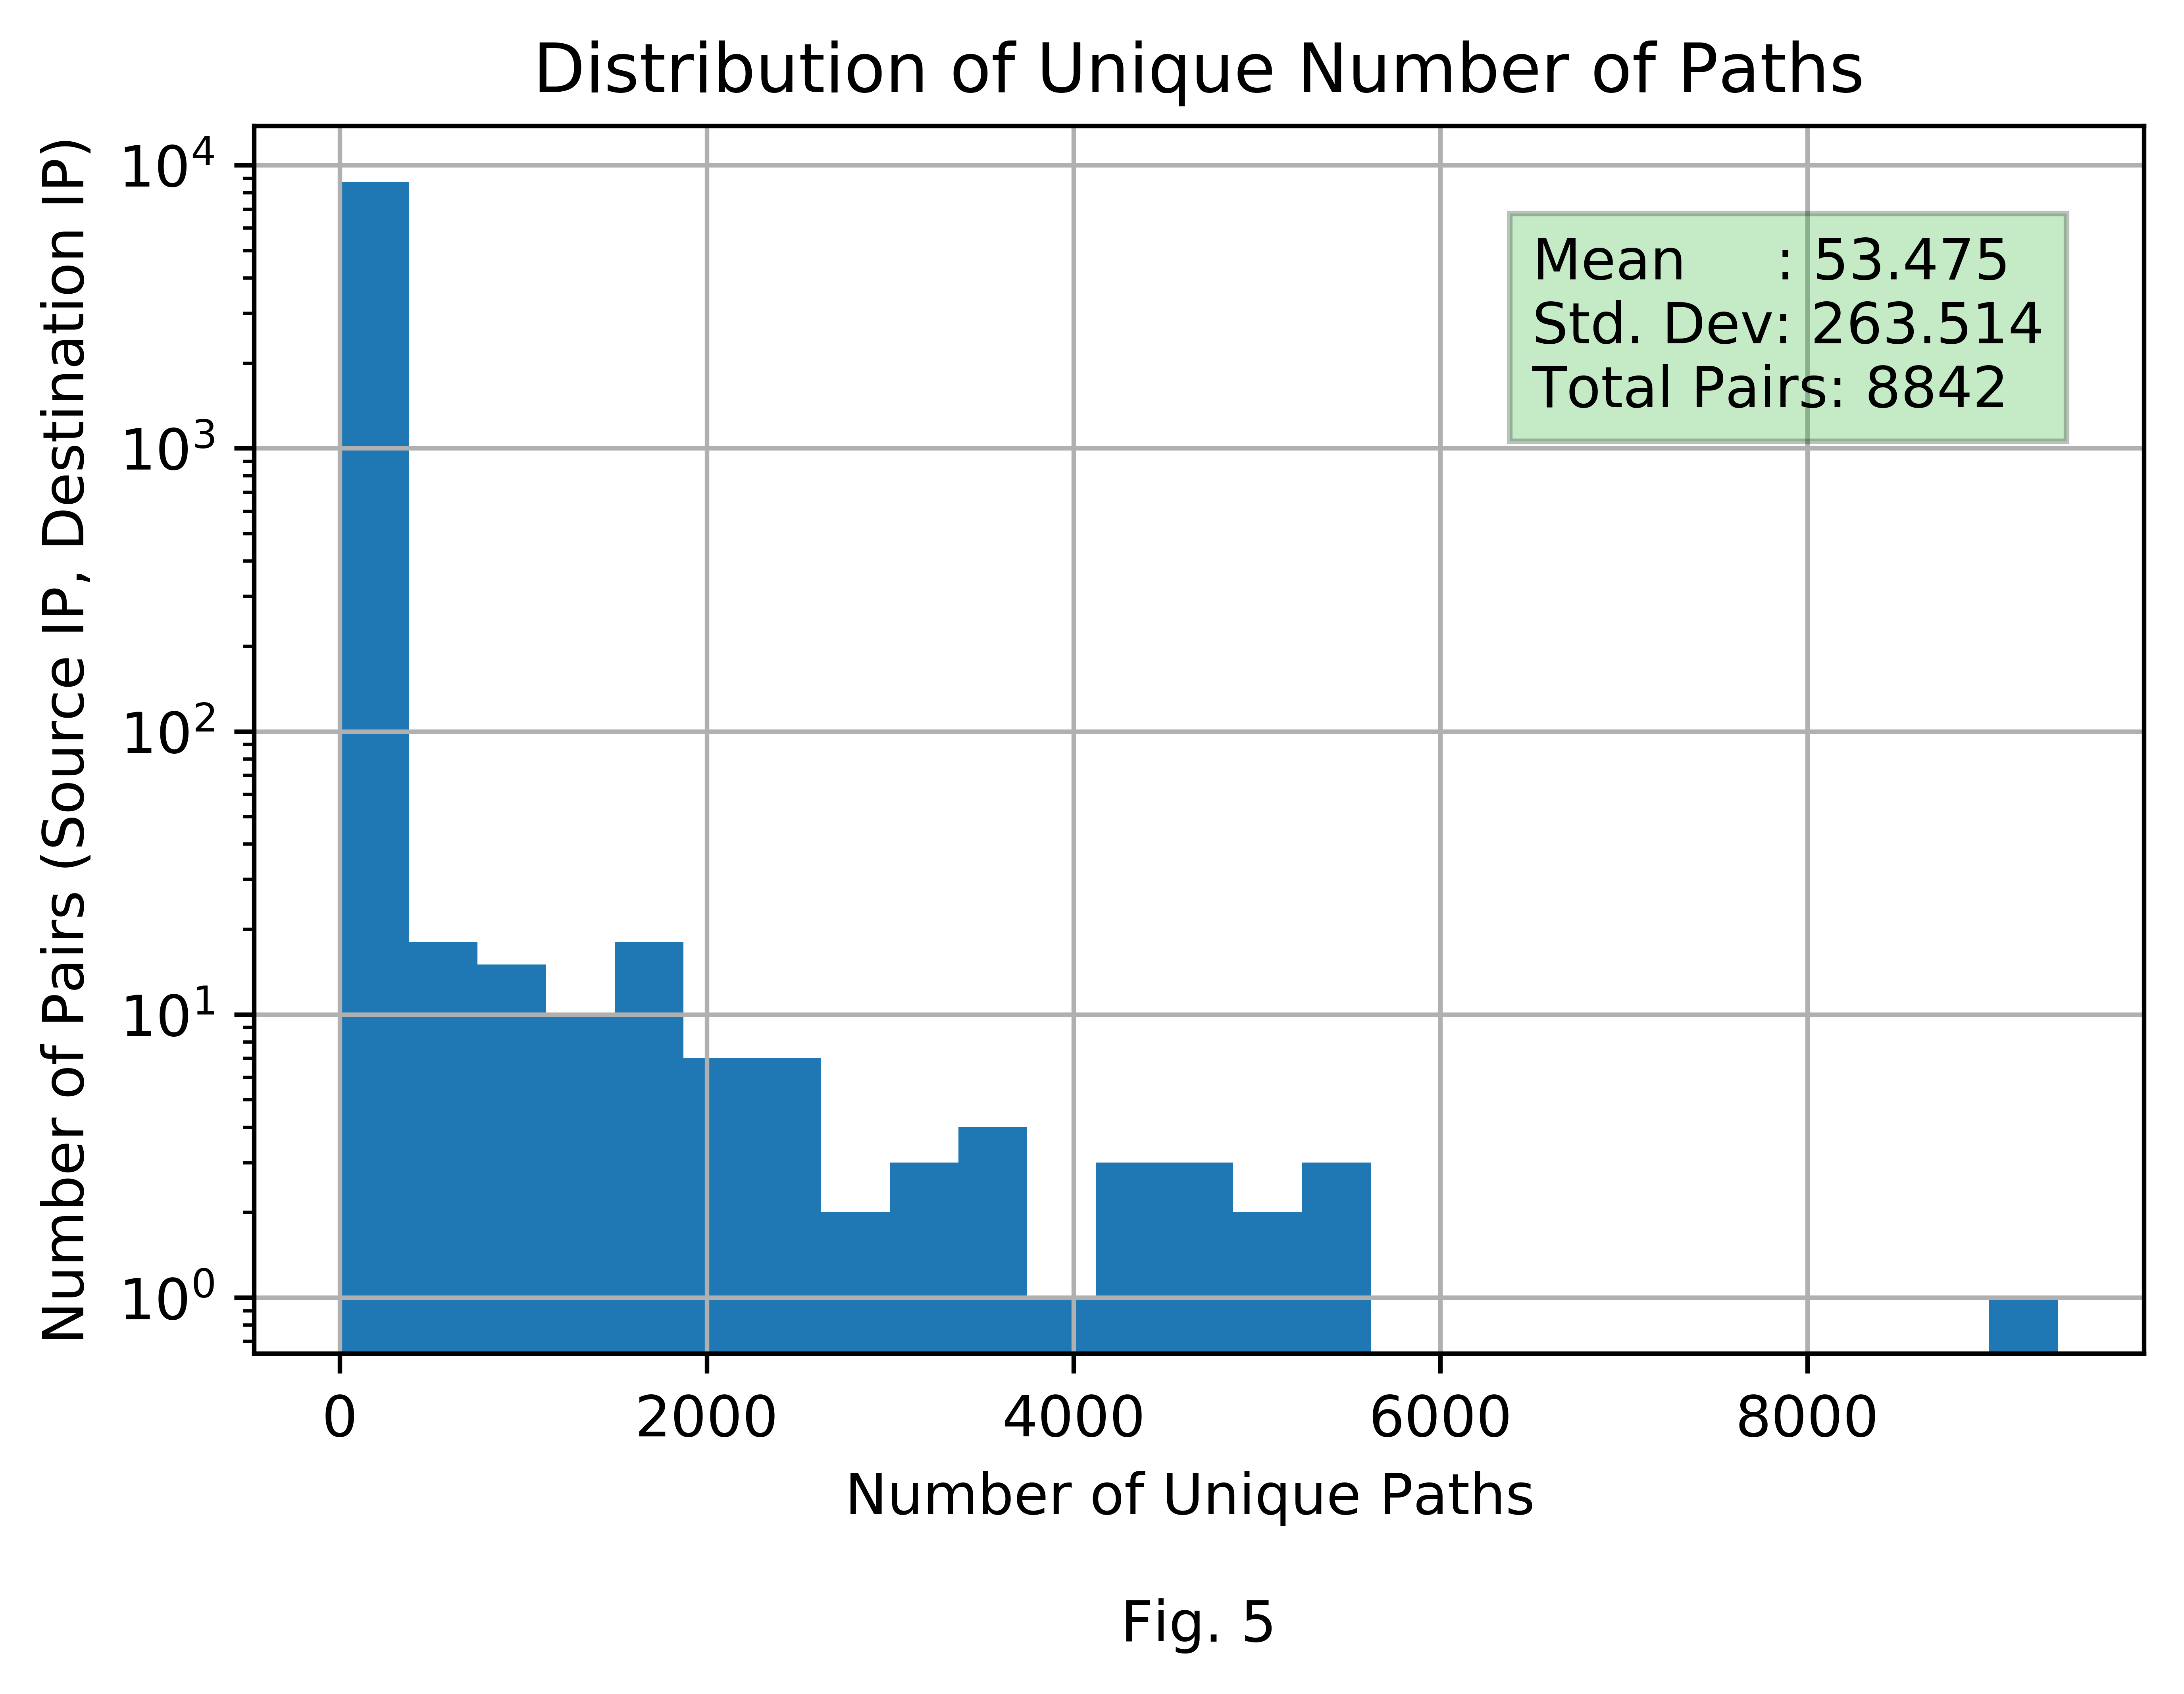

In [28]:
mean_total = src_dest_path_clean_df['Total'].mean()
stddev_total = src_dest_path_clean_df['Total'].std()
legend_data = "Mean     : {:3.3f}\nStd. Dev: {:3.3f}\nTotal Pairs: {:4d}"
plt.figure(dpi=1024)
src_dest_path_clean_df['Total'].hist(bins=25)
plt.title('Distribution of Unique Number of Paths')
plt.xlabel("Number of Unique Paths \n\nFig. 5")
plt.ylabel("Number of Pairs (Source IP, Destination IP)")
plt.yscale("log")
props = dict(facecolor='xkcd:green', alpha=0.25)
plt.text(6500, 1400, s=legend_data.format(mean_total, stddev_total, src_dest_path_clean_df.shape[0]), bbox=props)

In [58]:
src_dest_path_clean_df['Total'].sum()

472823